In [96]:
import pandas as pd 
import random 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

import researchpy as rp
import scipy.stats as stats
from scipy.stats import levene
from scipy.stats import kstest
from scipy.stats import skew

import math 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder  
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA



import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (20,10) 
pd.options.display.max_columns = None

In [97]:
df= pd.read_pickle('datos/cars_price_norm_est_an.pkl')
df.head(2)

,Levy,Prod_year,Category,Leather_interior,Fuel_type,Mileage,Cylinders,Gear_box_type,Drive_wheels,Airbags,Price_log
0,1.766963,-0.411248,Jeep,Yes,Hybrid,0.237134,1.375313,Automatic,4x4,1.329406,9.497622
1,0.943936,-0.173337,Jeep,No,Petrol,0.273438,1.375313,Tiptronic,4x4,0.319668,9.718422


##### <font color=green> Hacer una códificación de la/las variables categóricas que tengáis en vuestro set de datos.

##### <font color=green> Recordad que lo primero que deberéis hacer es decidir si vuestras variables tienen o no orden, para que en función de esto uséis una aproximación u otra.

In [98]:
df_categoricas = df.select_dtypes(include = ["object"])
df_categoricas.sample(10)

,Category,Leather_interior,Fuel_type,Gear_box_type,Drive_wheels
4913,Sedan,Yes,Petrol,Variator,Front
456,Goods wagon,No,Diesel,Manual,Front
4799,Sedan,Yes,Hybrid,Variator,Front
3092,Sedan,Yes,Diesel,Automatic,Front
9388,Goods wagon,No,Diesel,Manual,Rear
7820,Jeep,Yes,Petrol,Tiptronic,4x4
12676,Jeep,Yes,Diesel,Automatic,Front
1074,Sedan,Yes,Petrol,Tiptronic,Front
360,Sedan,Yes,Petrol,Automatic,Front
2119,Universal,No,Petrol,Manual,Front


Vemos visualmente las variables categóricas en comparación con el precio para sacar una primera conclusión de si tienen orden o no.

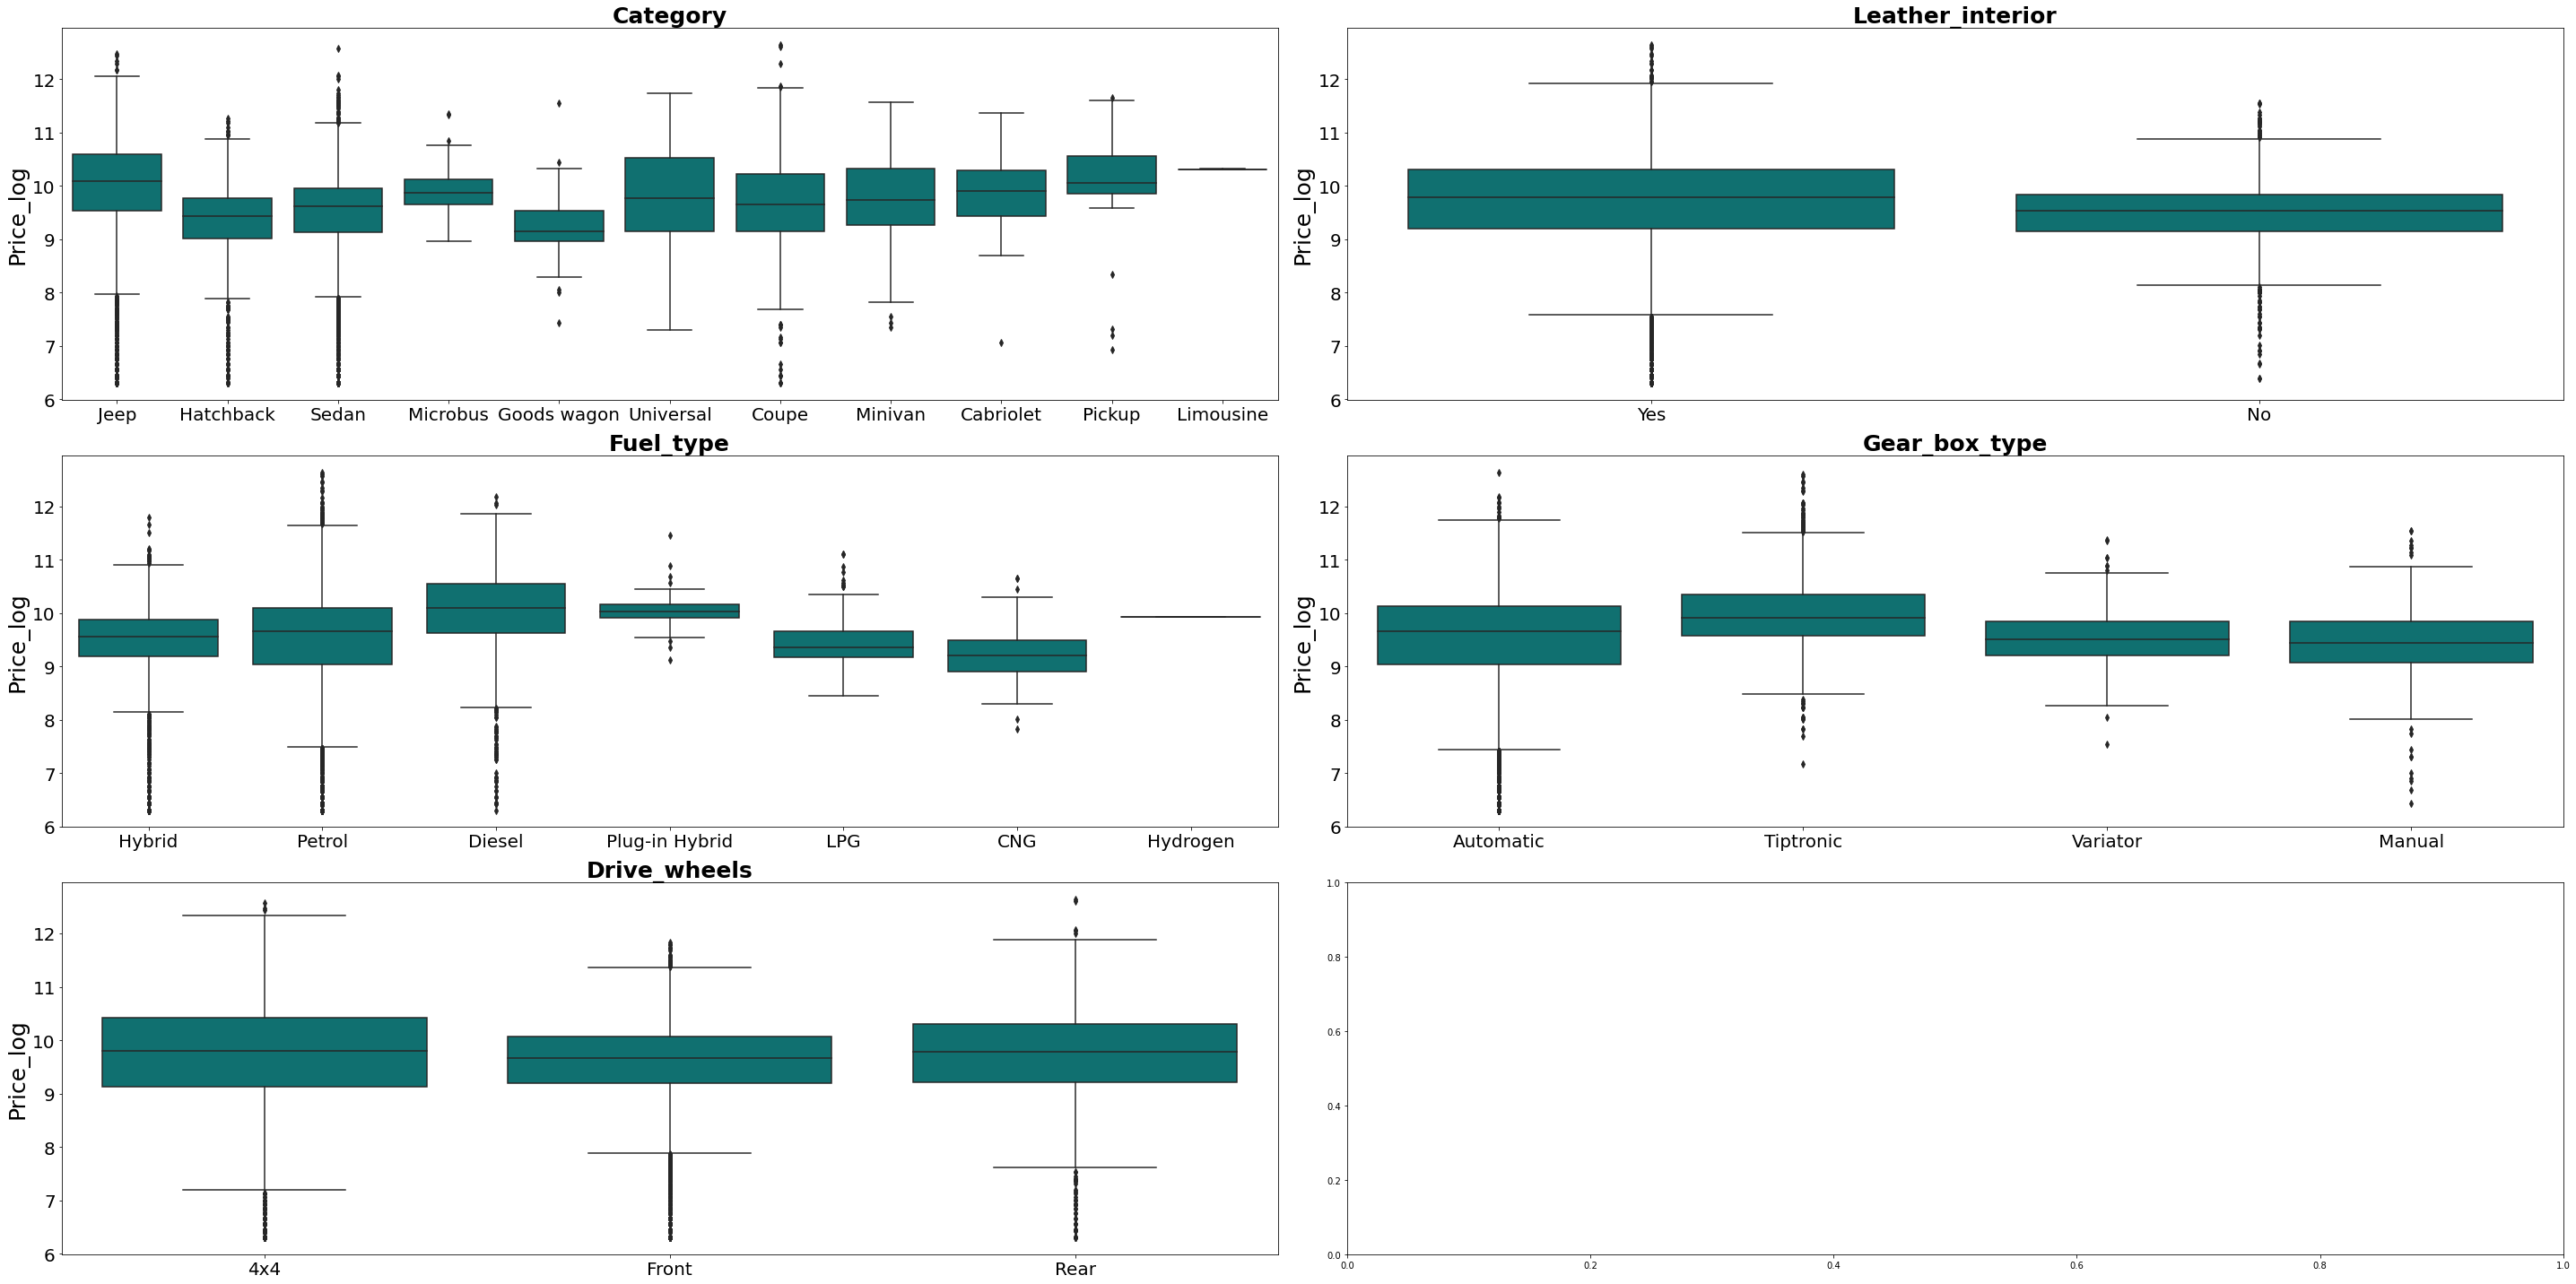

In [99]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (40, 20))


axes = axes.flat

columnas_cat = df.select_dtypes(include = ["object", "category"]).columns

for i, colum in enumerate(columnas_cat): 
    sns.boxplot(
        data = df,
        x = colum,
        y = "Price_log",
        color = "teal", 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 25, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel( "Price_log", fontsize = 25)

fig.tight_layout();

Observando las gráficas de las variables `Drive_wheels` `Gear_box_type` `Leather_interior` las podemos transformar a variables de tipo categóricas.

También podemos concluir lo siguiente:

Pensamos que las variables categóricas que tienen orden (ordinarias) son:
- "Leather_interior"


Pensamos que las variables categóricas que no tienen orden (nominales) son:
- "Fuel_type"
- "Gear_box_type"
- "Drive_wheels"
- "Category"



Hacemos la transformación de las variables `Drive_wheels` y `Gear_box_type` a tipo categórico.

In [100]:
df = df.astype({'Drive_wheels': 'category', 'Gear_box_type': 'category', 'Leather_interior': 'category','Category': 'category'})

Verificamos el tipo de datos de cada columna.

In [101]:
df.dtypes

Levy                 float64
Prod_year            float64
Category            category
Leather_interior    category
Fuel_type             object
Mileage              float64
Cylinders            float64
Gear_box_type       category
Drive_wheels        category
Airbags              float64
Price_log            float64
dtype: object

Sacamos los valores únicos de cada variable

In [102]:
df["Leather_interior"].unique() #Si tiene orden

['Yes', 'No']
Categories (2, object): ['No', 'Yes']

In [103]:
df["Fuel_type"].unique() #No tiene orden

array(['Hybrid', 'Petrol', 'Diesel', 'Plug-in Hybrid', 'LPG', 'CNG',
       'Hydrogen'], dtype=object)

In [104]:
df["Gear_box_type"].unique() #No tiene orden

['Automatic', 'Tiptronic', 'Variator', 'Manual']
Categories (4, object): ['Automatic', 'Manual', 'Tiptronic', 'Variator']

In [105]:
df["Drive_wheels"].unique() #No tiene orden

['4x4', 'Front', 'Rear']
Categories (3, object): ['4x4', 'Front', 'Rear']

In [106]:
df["Category"].unique() #No tiene orden

['Jeep', 'Hatchback', 'Sedan', 'Microbus', 'Goods wagon', ..., 'Coupe', 'Minivan', 'Cabriolet', 'Pickup', 'Limousine']
Length: 11
Categories (11, object): ['Cabriolet', 'Coupe', 'Goods wagon', 'Hatchback', ..., 'Minivan', 'Pickup', 'Sedan', 'Universal']

Variables categóricas que tienen orden (ordinarias) son:
- "Leather_interior"


Variables categóricas que no tienen orden (nominales) son:
- "Fuel_type"
- "Gear_box_type"
- "Drive_wheels"
- "Category"
- "Doors"

<font color=violet>Para nuestras variables que tienen orden, vamos a utilizar el label enconding

In [107]:
df.Leather_interior.unique()

['Yes', 'No']
Categories (2, object): ['No', 'Yes']

In [108]:
le = LabelEncoder()

df['Leather_interior_le']=le.fit_transform(df['Leather_interior'])


In [109]:
df.head()

,Levy,Prod_year,Category,Leather_interior,Fuel_type,Mileage,Cylinders,Gear_box_type,Drive_wheels,Airbags,Price_log,Leather_interior_le
0,1.766963,-0.411248,Jeep,Yes,Hybrid,0.237134,1.375313,Automatic,4x4,1.329406,9.497622,1
1,0.943936,-0.173337,Jeep,No,Petrol,0.273438,1.375313,Tiptronic,4x4,0.319668,9.718422,0
2,-1.255121,-1.362894,Hatchback,No,Petrol,0.321884,-0.411095,Variator,Front,-1.194937,9.043932,0
3,0.606949,-0.173337,Jeep,Yes,Hybrid,0.133949,-0.411095,Automatic,4x4,-1.699806,8.190632,1
4,-0.291683,0.540397,Hatchback,Yes,Petrol,-0.332738,-0.411095,Automatic,Front,-0.690069,9.369564,1


<font color=violet>Para nuestras variables que no tienen orden, vamos a utilizar el método get_dummies encoding

In [110]:
df_categoricas = df.select_dtypes(include = ["object", "category"])
df_categoricas.sample(10)

,Category,Leather_interior,Fuel_type,Gear_box_type,Drive_wheels
1784,Jeep,Yes,Diesel,Automatic,Front
8977,Jeep,Yes,Petrol,Automatic,Front
12643,Sedan,Yes,Petrol,Automatic,Front
12290,Sedan,Yes,Petrol,Tiptronic,Front
2408,Jeep,Yes,Diesel,Automatic,4x4
9131,Microbus,No,Diesel,Manual,Front
11017,Sedan,Yes,Petrol,Tiptronic,Front
1975,Sedan,Yes,Petrol,Automatic,4x4
11127,Sedan,Yes,Hybrid,Automatic,Front
13087,Sedan,Yes,Petrol,Automatic,Front


Hacemos un dataframe de cada variable categórica aplicando el get_dummies encoding.

In [111]:
dummies1 = pd.get_dummies(df_categoricas["Fuel_type"], prefix_sep = "_", prefix = "Fuel_type", dtype = int)
dummies1.head(2)

,Fuel_type_CNG,Fuel_type_Diesel,Fuel_type_Hybrid,Fuel_type_Hydrogen,Fuel_type_LPG,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid
0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0


In [112]:
dummies2 = pd.get_dummies(df_categoricas["Gear_box_type"], prefix_sep = "_", prefix = "Gear_box_type", dtype = int)
dummies2.head(2)

,Gear_box_type_Automatic,Gear_box_type_Manual,Gear_box_type_Tiptronic,Gear_box_type_Variator
0,1,0,0,0
1,0,0,1,0


In [113]:
dummies3 = pd.get_dummies(df_categoricas["Drive_wheels"], prefix_sep = "_", prefix = "Drive_wheels", dtype = int)
dummies3.head(2)

,Drive_wheels_4x4,Drive_wheels_Front,Drive_wheels_Rear
0,1,0,0
1,1,0,0


In [114]:
dummies4 = pd.get_dummies(df_categoricas["Category"], prefix_sep = "_", prefix = "Category", dtype = int)
dummies4.head(2)

,Category_Cabriolet,Category_Coupe,Category_Goods wagon,Category_Hatchback,Category_Jeep,Category_Limousine,Category_Microbus,Category_Minivan,Category_Pickup,Category_Sedan,Category_Universal
0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0


Vamos a hacer un concat para juntar todos nuestros datos luego de aplicar el label encoding y el get_dummies encoding a cada variable.

In [115]:
df_encoding = pd.concat([df, dummies1, dummies2, dummies3, dummies4], axis = 1)
df_encoding.head(2)

,Levy,Prod_year,Category,Leather_interior,Fuel_type,Mileage,Cylinders,Gear_box_type,Drive_wheels,Airbags,Price_log,Leather_interior_le,Fuel_type_CNG,Fuel_type_Diesel,Fuel_type_Hybrid,Fuel_type_Hydrogen,Fuel_type_LPG,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,Gear_box_type_Automatic,Gear_box_type_Manual,Gear_box_type_Tiptronic,Gear_box_type_Variator,Drive_wheels_4x4,Drive_wheels_Front,Drive_wheels_Rear,Category_Cabriolet,Category_Coupe,Category_Goods wagon,Category_Hatchback,Category_Jeep,Category_Limousine,Category_Microbus,Category_Minivan,Category_Pickup,Category_Sedan,Category_Universal
0,1.766963,-0.411248,Jeep,Yes,Hybrid,0.237134,1.375313,Automatic,4x4,1.329406,9.497622,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0.943936,-0.173337,Jeep,No,Petrol,0.273438,1.375313,Tiptronic,4x4,0.319668,9.718422,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0



##### <font color=green> Guardad el dataframe, donde deberíais tener las variables estadandarizadas, normalizadas y codificadas en un csv para usarlo en el próximo pairprogramming

Dropeamos las columnas originales para quedarnos con las estandarizadas.

In [116]:
df_encoding.drop(["Leather_interior","Fuel_type","Gear_box_type","Drive_wheels", "Category"], axis = 1, inplace = True)
df_encoding.head(2)

,Levy,Prod_year,Mileage,Cylinders,Airbags,Price_log,Leather_interior_le,Fuel_type_CNG,Fuel_type_Diesel,Fuel_type_Hybrid,Fuel_type_Hydrogen,Fuel_type_LPG,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,Gear_box_type_Automatic,Gear_box_type_Manual,Gear_box_type_Tiptronic,Gear_box_type_Variator,Drive_wheels_4x4,Drive_wheels_Front,Drive_wheels_Rear,Category_Cabriolet,Category_Coupe,Category_Goods wagon,Category_Hatchback,Category_Jeep,Category_Limousine,Category_Microbus,Category_Minivan,Category_Pickup,Category_Sedan,Category_Universal
0,1.766963,-0.411248,0.237134,1.375313,1.329406,9.497622,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0.943936,-0.173337,0.273438,1.375313,0.319668,9.718422,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [117]:
df_encoding.to_pickle('datos/cars_price_norm_est_cod.pkl')

In [118]:
df_encoding.to_csv('datos/cars_price_norm_est_cod.csv')